In [81]:
import pandas as pd

import numpy as np
from scipy import stats

import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2


# Exploring ultrasound probes requests on eBay

I've been using the eBay API to scrap ultrasound probes, and I want to get specific type of probes (collector/vintage as in _mechanical_ probes). Sellers do little to help one with providing the details, usually for the collector. So, the idea is to extract these probes ("MechProbes" class) from the larger sets.

The dataset contains data from the API itself, plus some classification already done (some manual, some automatic) and some items, classified "None" are yet to be classified.

Let's go !

In [5]:
df = pd.read_excel("dfAll.xlsx")

In [11]:
print("There are",len(df), "items.")
print("Keys: ",", ".join(df.keys().to_list()))

There are 24336 items.
Keys:  Unnamed: 0, ItemID, value, _currencyID, ViewItemURLForNaturalSearch, Title, PrimaryCategoryID, Country, Description, group


# Content

We should have the eBay ID, object value and currency, its URL, its title, category, country, description, and the manual "group" classification.

In [19]:
# Before, let's make sure that its PrimaryCategory and IDs are categories
df = df.drop(df.columns[0], axis=1)
df["PrimaryCategoryID"] = df["PrimaryCategoryID"].astype('category')
df["ItemID"] = df["ItemID"].astype('category')

In [20]:
df.head(2)

,ItemID,value,_currencyID,ViewItemURLForNaturalSearch,Title,PrimaryCategoryID,Country,Description,group
0,401682438519,1139.67,USD,https://www.ebay.com/itm/Toshiba-PVT-770RT-End...,Toshiba PVT-770RT Endorectal (biplane) Transdu...,184515,AU,<!-- /* General Settings ::::::::::::::::::::...,Array
1,293250724359,24.93,USD,https://www.ebay.com/itm/TOYOTA-AVENSIS-VVTI-1...,"TOYOTA AVENSIS, VVTI,1.8 MASS AIRFLOW METER SE...",173865,GB,WELCOME TO A1 MOTOR GROUPPART FOR SALEUp for s...,NotUS


# Checking that the groups are like

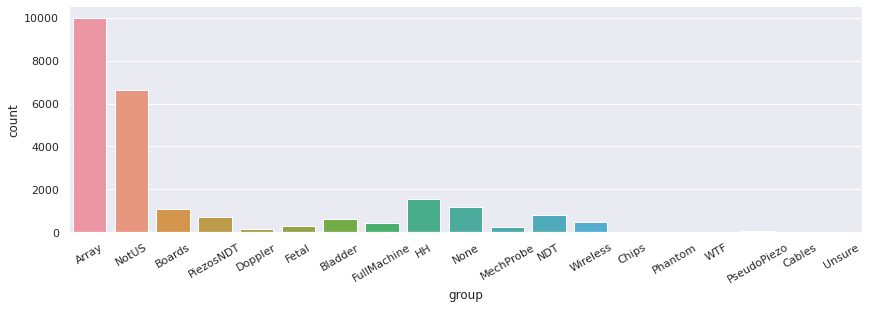

In [39]:
g = sns.factorplot("group", data=df, kind="count", height=4, aspect=3)
g.set_xticklabels(rotation=30)

# Let's see what we can do with the titles

In [82]:
df['Title_Clean'] = df['Title'].str.replace("\r", " ")
df['Title_Clean'] = df['Title_Clean'].str.replace("\n", " ")
df['Title_Clean'] = df['Title_Clean'].str.replace("    ", " ")
df['Title_Clean'] = df['Title_Clean'].str.replace('"', '')
df['Title_Clean'] = df['Title_Clean'].str.lower()

punctuation_signs = list('?:!,;-/*"')

for punct_sign in punctuation_signs:
    df['Title_Clean'] = df['Title_Clean'].str.replace(punct_sign, '')
    
df['Title_Clean'] = df['Title_Clean'].str.replace("'s", "")

In [84]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/kelu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kelu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [85]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    # Save the text and its words into an object
    text = df.loc[row]['Title_Clean']
    text_words = text.split(" ")
    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [86]:
df['Title_Clean'] = lemmatized_text_list
df['Title_Clean']

0        toshiba pvt770rt endorectal (biplane) transduc...
1        toyota avensis vvti1.8 mass airflow meter sens...
2        siemens 7kg61133ek170b current transducer tddm...
3        toshiba plt1204ax linear transducer probe apli...
4        aloka prosound ssd3500 plus ultrasound system ...
                               ...                        
24331    wireless portable ultrasound scanner linear ar...
24332    1ss315  toshiba schotty barriera diodo  5v30ma...
24333    oscilloscopio analogico  hitachi v425 40mhz  d...
24334       sonosite 180 plus hand carry ultrasound system
24335    diagnostic ultrasound corporation  bvi 3000 05...
Name: Title_Clean, Length: 24336, dtype: object

In [87]:
# Downloading the stop words list
nltk.download('stopwords')
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

from tqdm.notebook import trange, tqdm

for stop_word in tqdm(stop_words, 
                         total=len(stop_words), 
                         desc="Processing records"):
    regex_stopword = r"\b" + stop_word + r"\b"
    df['Title_Clean'] = df['Title_Clean'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /home/kelu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Checking n-grams per category

### In order to extract features, let's see what keywords often come back in the titles.

In [327]:
X_train, X_test, y_train, y_test = train_test_split(df['Title_Clean'], 
                                                    df['group'], 
                                                    test_size=0.15, 
                                                    random_state=8)

ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

from sklearn.feature_selection import chi2
import numpy as np

InitialKeywords = []
for category_id in sorted(df.group.unique().tolist()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    for k in unigrams[:25]:
        InitialKeywords.append(k)
    print("# '{}' category:".format(category_id))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

(20685, 300)
(3651, 300)
# 'Array' category:
  . Most correlated unigrams:
. ultrasonic
. array
. ultrasound
. transducer
. ge
  . Most correlated bigrams:
. transducer probe
. ultrasound transducer

# 'Bladder' category:
  . Most correlated unigrams:
. 3000
. bladderscan
. bvi
. verathon
. bladder
  . Most correlated bigrams:
. bvi 3000
. bladder scanner

# 'Boards' category:
  . Most correlated unigrams:
. 5000
. hdi
. assy
. pcb
. board
  . Most correlated bigrams:
. atl hdi
. hdi 5000

# 'Cables' category:
  . Most correlated unigrams:
. ce
. cable
. compatible
. medical
. series
  . Most correlated bigrams:
. ultrasound new
. transducer head

# 'Chips' category:
  . Most correlated unigrams:
. probe
. ultrasound
. mhz
. hitachi
. module
  . Most correlated bigrams:
. ultrasound probe
. ultrasound transducer

# 'Doppler' category:
  . Most correlated unigrams:
. atl
. mhz
. ultraschallgerät
. doppler
. cw
  . Most correlated bigrams:
. probe ultrasound
. transducer ultrasound

# 'F

In [344]:
print(len(InitialKeywords)," words.\n",len(list(set(InitialKeywords)))," unique words.\n",list(set(InitialKeywords)))

475  words.
 148  unique words.
 ['1mhz', 'iu22', 'fetal', 'c52', 'original', 'digital', 'new', 'medison', 'transducteur', 'fda', 'peugeot', 'diagnostic', 'series', 'german', 'quality', '2mhz', 'wireless', 'mindray', '3d', 'detector', 'medical', 'cable', 'free', 'straight', 'ultraschallgerät', 'vet', 'ultraschall', 'doppler', 'monitor', 'memory', 'untested', 'box', 'ultraschallsonde', 'work', 'image', 'demo', 'ddr3', 'umwandler', 'portable', 'heartbeat', 'intel', 'logiq', 'sequoia', 'transvaginal', 'linear', 'tofd', 'scanner', 'probe', 'use', 'hdi', 'shape', 'set', 'part', 'animal', 'case', 'hp', 'temperature', 'veterinary', 'plug', 'toshiba', 'power', 'für', 'abdominal', 'vascular', 'baby', 'pcb', 'pn', 'atl', 'battery', 'diasonics', 'microconvex', '4x', 'meter', 'fan', 'temp', '3000', 'replacement', 'wifi', 'pad', 'ce', 'sonoscape', 'c84v', 'neu', 'samsung', 'assy', 'cardiac', 'warranty', 'bard', 'ii', 'ultrason', 'transducer', 'therapy', 'ge', 'handheld', 'mhz', 'pro', 'site', 'tee'

# Let's have a manual sort for keywords in the titles, for extracting a couple of features

In [346]:
## Adding a few manual keywords
KeyWords = InitialKeywords + ["transducer","array","aloka","ultrasound","ultrason","board",
            "assy","ndt","piezo","probe","linear","convex","doppler",
            "vet"]
KeyWords = set(KeyWords)
KeyWords = list(KeyWords)
print(len(KeyWords),"keywords\n",KeyWords)

154 keywords
 ['1mhz', 'iu22', 'fetal', 'c52', 'original', 'convex', 'digital', 'new', 'medison', 'transducteur', 'fda', 'peugeot', 'diagnostic', 'series', 'german', 'quality', '2mhz', 'wireless', 'mindray', '3d', 'detector', 'medical', 'cable', 'free', 'straight', 'ultraschallgerät', 'vet', 'ultraschall', 'doppler', 'monitor', 'memory', 'untested', 'box', 'ultraschallsonde', 'work', 'image', 'demo', 'ddr3', 'umwandler', 'portable', 'heartbeat', 'intel', 'logiq', 'sequoia', 'transvaginal', 'linear', 'tofd', 'scanner', 'probe', 'use', 'hdi', 'shape', 'ndt', 'set', 'part', 'animal', 'case', 'hp', 'temperature', 'veterinary', 'plug', 'toshiba', 'power', 'für', 'abdominal', 'vascular', 'baby', 'pcb', 'pn', 'atl', 'battery', 'diasonics', 'array', 'microconvex', '4x', 'meter', 'fan', 'temp', '3000', 'replacement', 'wifi', 'pad', 'ce', 'sonoscape', 'c84v', 'neu', 'samsung', 'assy', 'cardiac', 'warranty', 'bard', 'ii', 'ultrason', 'transducer', 'therapy', 'ge', 'handheld', 'mhz', 'pro', 'site'

## Creating the features table from there.

In [347]:
df = df[df.columns.drop(list(df.filter(regex='kw')))]
import random
for kw in tqdm(KeyWords,total=len(KeyWords), desc="Processing KeyWords"):
    df["kw_"+kw] = df.Title_Clean.apply( lambda x: 0.999  if kw in x.split(" ") else 0.001)

# Creating objective: probes in the "Array" group.

In [348]:
category_codes = {}
category_names = {}
i = 0
for k in df.group.unique().tolist():
    seed = random.randint(0, 1000)/10000000.0
    if "Array" in k:
        category_codes[k] = 1# =i
    else:
        category_codes[k] = 0# =i           
    category_names[i] = k
    i += 1
df['Category_Code'] = df['group']
df = df.replace({'Category_Code':category_codes})

# Creating test.train data

In [349]:
# @todo  check https://datascienceplus.com/multiple-logistic-regression-in-python/
X_train, X_test, y_train, y_test = train_test_split(df[ [x for x in df.columns if "kw" in x ] ], 
                                                    df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

# Checking the correlations for the different keywords indicating the category we're looking for

In [335]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.296624
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/kelu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.562     
Dependent Variable:   Category_Code      AIC:                12579.3435
Date:                 2020-05-09 13:18   BIC:                13801.6668
No. Observations:     20685              Log-Likelihood:     -6135.7   
Df Model:             153                LL-Null:            -14007.   
Df Residuals:         20531              LLR p-value:        0.0000    
Converged:            0.0000             Scale:              1.0000    
-----------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------
kw_1mhz             -0.8285   0.3626  -2.2847 0.0223   -1.5393  -0.1177
kw_iu22              0.3159   0.3597   0.8783 0.3798   -0.3891   1.0209
kw_fetal            -1.0899   0.3238  -3.3663 0.0008   -1.7245  -0.4553
kw_c52               

# Out of curiosity, can we check a few correlation between keywords occurence ?

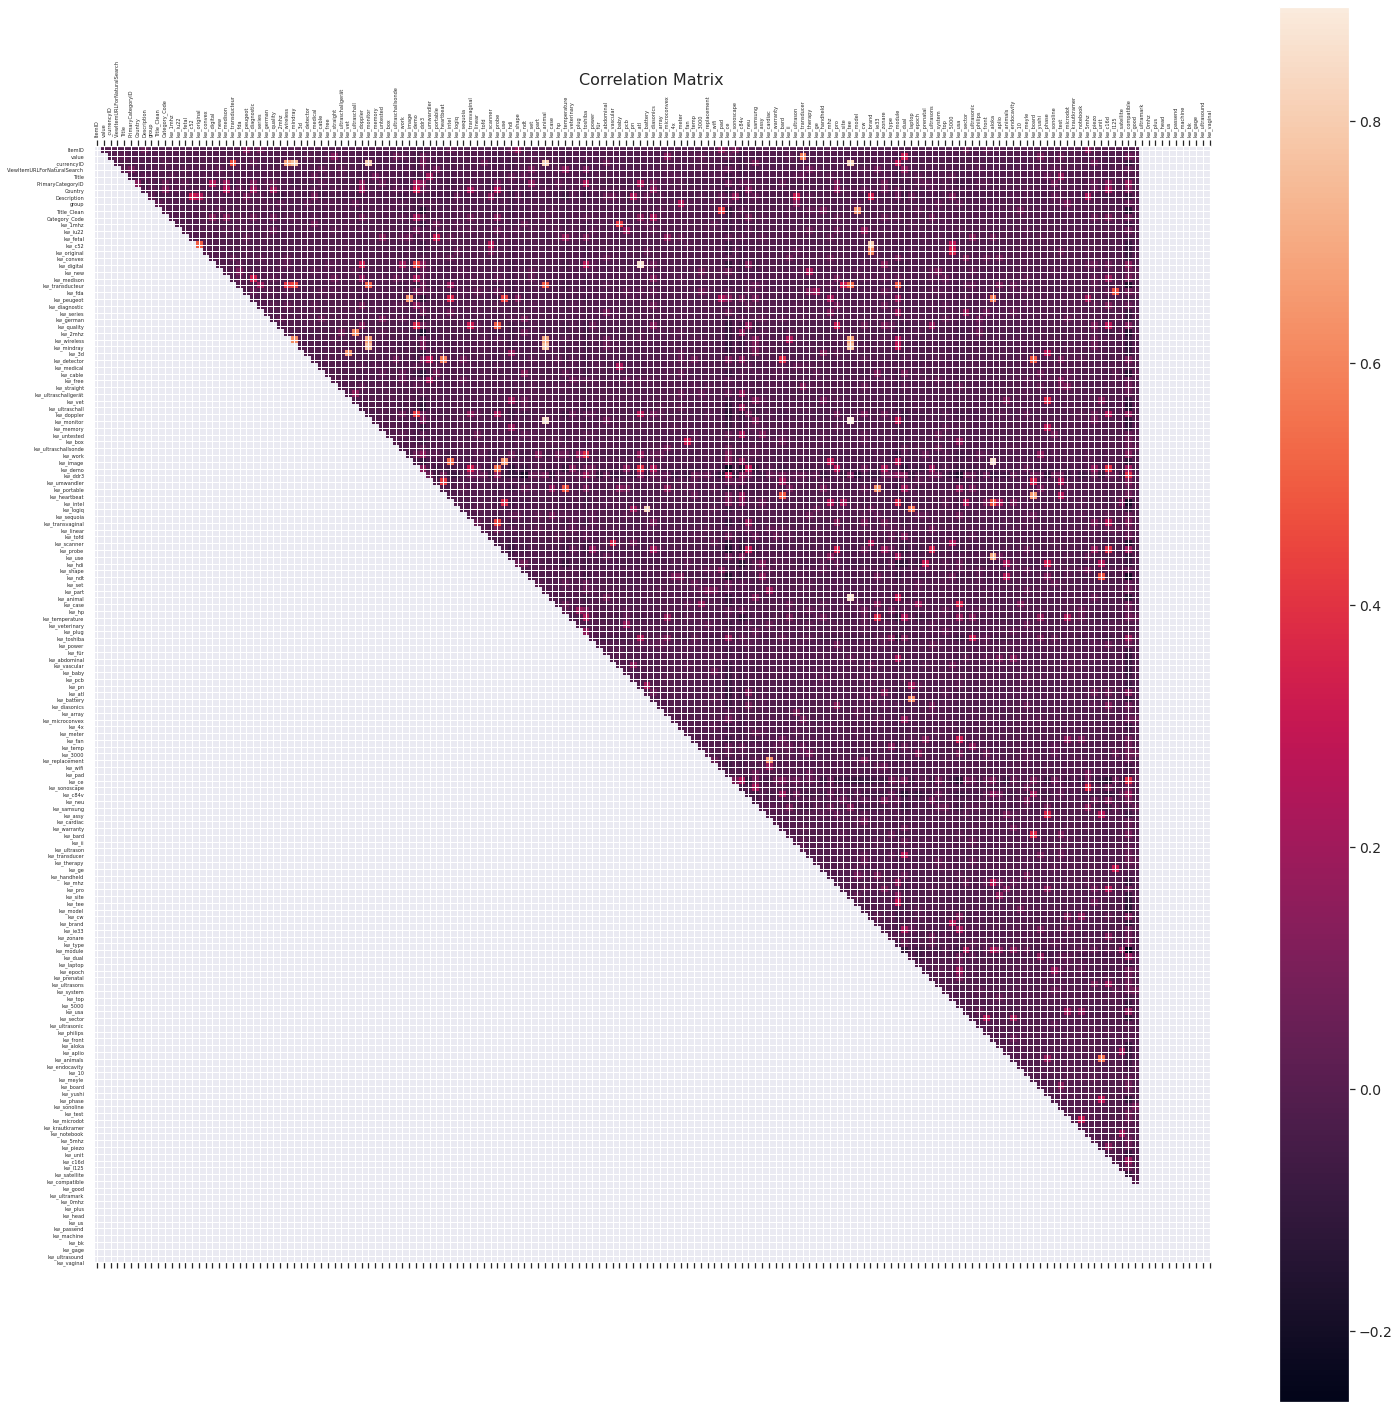

In [350]:
corr_matrix = X_train.corr()
# keeping only half triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# plotting
f = plt.figure(figsize=(25, 25))
plt.matshow(upper, fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=5, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Applying a classifier to our model

In [351]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


# Checking for the confusion matrix

In [352]:
from sklearn.metrics import confusion_matrix
print(len(y_test),"items on which to test")
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

3651 items on which to test
[[1979  169]
 [ 136 1367]]


# Conclusion: we've had some fun exploring custom data, cleaning it, visualising it, and extracting a model that learns about the category of an item =)